# Integration and Observability


Please read the full article at [thedataguy.pro](https://thedataguy.pro/blog/ntegrations-and-observability-with-ragas/).


In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [4]:
import nest_asyncio
nest_asyncio.apply()

In [6]:
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

from ragas.evaluation import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall



In [7]:

# Load all markdown files from the data directory
loader = DirectoryLoader("data/", glob="**/*.md")
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
splits = text_splitter.split_documents(documents)


In [8]:
# Create vector store and retriever
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(splits, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

# Create QA chain
llm = ChatOpenAI(model="gpt-4o", temperature=0)
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever
)



In [14]:
# Generate test questions (or use your own)
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset import TestsetGenerator
generator_llm = LangchainLLMWrapper(llm)
generator_embeddings = LangchainEmbeddingsWrapper(embeddings)
generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(splits, testset_size=10)


Applying SummaryExtractor:   0%|          | 0/10 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/14 [00:00<?, ?it/s]

Node de498378-a3a6-434e-a7e4-6e2a31c5e936 does not have a summary. Skipping filtering.
Node 0d39de02-5eb4-42ca-875d-f7dba1ab8574 does not have a summary. Skipping filtering.
Node dbd3ea6c-70ad-45a9-8f17-6bca1e6ec8ff does not have a summary. Skipping filtering.
Node b6319057-6b1c-4775-b7b0-f5459cbb3f2b does not have a summary. Skipping filtering.


Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/38 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,what new in version 10.0.23?,[title: Platform updates for version 10.0.23 o...,The platform updates for version 10.0.23 of fi...,single_hop_specifc_query_synthesizer
1,What happen in January 2022?,[General availability of release (auto-update)...,General availability of release (auto-update):...,single_hop_specifc_query_synthesizer
2,how do i find bug fixes in microsoft dynamics ...,[Bug fixes\n\nFor information about the bug fi...,"To find information about bug fixes, sign in t...",single_hop_specifc_query_synthesizer
3,When was the preview release of version 10.0.2...,[title: Platform updates for version 10.0.22 o...,The preview release of version 10.0.22 of the ...,single_hop_specifc_query_synthesizer
4,When was the general availability of the release?,[General availability of release (auto-update)...,The general availability of the release was in...,single_hop_specifc_query_synthesizer
5,Wht r the diffrnces in the global availbility ...,[<1-hop>\n\ntitle: Platform updates for versio...,The global availability schedule for version 1...,multi_hop_specific_query_synthesizer
6,How does the upgrade to release 10.0.22 enhanc...,[<1-hop>\n\nan environment is upgraded to rele...,The upgrade to release 10.0.22 enhances Power ...,multi_hop_specific_query_synthesizer
7,What were the key features introduced in the J...,[<1-hop>\n\nGeneral availability of release (a...,In the January 2022 general availability relea...,multi_hop_specific_query_synthesizer
8,How does the integration of Microsoft Power Au...,[<1-hop>\n\ncan be integrated with any automat...,The integration of Microsoft Power Automate wi...,multi_hop_specific_query_synthesizer
9,What are the key features and deprecations inc...,[<1-hop>\n\nCheck out the Dynamics 365 and ind...,The Dynamics 365 and industry clouds: 2021 rel...,multi_hop_specific_query_synthesizer


## Build RAG Graph


In [20]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)


def retrieve(state):
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}


def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
  response = llm.invoke(messages)
  return {"response" : response.content}


from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str



graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()



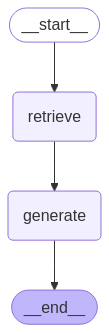

In [22]:
from IPython.display import Image

# visualize the graph
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [23]:
# Execute RAG pipeline
for test_row in dataset:
  response = graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [24]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,what new in version 10.0.23?,[title: Platform updates for version 10.0.23 o...,[title: Platform updates for version 10.0.23 o...,The context provided does not include specific...,The platform updates for version 10.0.23 of fi...,single_hop_specifc_query_synthesizer
1,What happen in January 2022?,[General availability of release (auto-update)...,[General availability of release (auto-update)...,"In January 2022, the platform updates for vers...",General availability of release (auto-update):...,single_hop_specifc_query_synthesizer
2,how do i find bug fixes in microsoft dynamics ...,[Bug fixes\n\nFor information about the bug fi...,[Bug fixes\n\nFor information about the bug fi...,To find bug fixes in Microsoft Dynamics Lifecy...,"To find information about bug fixes, sign in t...",single_hop_specifc_query_synthesizer
3,When was the preview release of version 10.0.2...,[title: Platform updates for version 10.0.22 o...,[title: Platform updates for version 10.0.22 o...,The preview release of version 10.0.22 of the ...,The preview release of version 10.0.22 of the ...,single_hop_specifc_query_synthesizer
4,When was the general availability of the release?,[General availability of release (auto-update)...,[General availability of release (auto-update)...,The general availability of the release (auto-...,The general availability of the release was in...,single_hop_specifc_query_synthesizer
5,Wht r the diffrnces in the global availbility ...,[title: Platform updates for version 10.0.23 o...,[<1-hop>\n\ntitle: Platform updates for versio...,The differences in the global availability sch...,The global availability schedule for version 1...,multi_hop_specific_query_synthesizer
6,How does the upgrade to release 10.0.22 enhanc...,[an environment is upgraded to release 10.0.22...,[<1-hop>\n\nan environment is upgraded to rele...,The upgrade to release 10.0.22 enhances Power ...,The upgrade to release 10.0.22 enhances Power ...,multi_hop_specific_query_synthesizer
7,What were the key features introduced in the J...,[General availability of release (auto-update)...,[<1-hop>\n\nGeneral availability of release (a...,The key feature introduced in the January 2022...,In the January 2022 general availability relea...,multi_hop_specific_query_synthesizer
8,How does the integration of Microsoft Power Au...,[can be integrated with any automation by usin...,[<1-hop>\n\ncan be integrated with any automat...,The integration of Microsoft Power Automate wi...,The integration of Microsoft Power Automate wi...,multi_hop_specific_query_synthesizer
9,What are the key features and deprecations inc...,[Additional resources\n\nBug fixes\n\nFor info...,[<1-hop>\n\nCheck out the Dynamics 365 and ind...,The key features included in the Dynamics 365 ...,The Dynamics 365 and industry clouds: 2021 rel...,multi_hop_specific_query_synthesizer


In [25]:
from ragas import EvaluationDataset
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

#Using gpt-4.1 for evaluation
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))

# Evaluate the retriever component
custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[28]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-XyIrJZx8AUgCzADN6GcfWGO6 on tokens per min (TPM): Limit 30000, Used 29509, Requested 1431. Please try again in 1.879s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Exception raised in Job[13]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-XyIrJZx8AUgCzADN6GcfWGO6 on tokens per min (TPM): Limit 30000, Used 29362, Requested 2024. Please try again in 2.772s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Exception raised in Job[24]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-XyIrJZx8AUgCzADN6GcfWGO6 on tokens per min (TPM): Limit 30000, Used 29884, Reque

In [26]:
result

{'context_recall': 0.9583, 'faithfulness': 0.8273, 'factual_correctness': 0.5780, 'answer_relevancy': 0.7563, 'context_entity_recall': 0.4914, 'noise_sensitivity_relevant': 0.1135}

In [ ]:
result.to_pandas().to_csv("data/ragas_evaluation.csv", index=False)

# LangSmith Integration

Signup for [LangSmith](https://smith.langchain.com/) for free and get your API key.

In [ ]:
import os
import getpass
# Set up environment variables for LangSmith
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key:") # LangChain or LangSmith API key
os.environ["LANGCHAIN_PROJECT"] = "07_Integrations_and_Observability"

In [ ]:

from langsmith import Client

client = Client()

dataset_name = "07_Integrations_and_Observability"
dataset_desc = "Test dataset for Ragas evaluation with LangSmith"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description=dataset_desc
)


# convert RAGAS dataset to LangSmith format
# simple example, production code should bulk upload
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

In [ ]:
from ragas.integrations.langsmith import evaluate

experiment_name = "my-first-ragas-langsmith-experiment"

metrics_to_use = [LLMContextRecall()]
evaluation_results = evaluate(
        dataset_name=dataset_name,
        llm_or_chain_factory=graph,
        metrics=metrics_to_use,
        experiment_name=experiment_name,
        verbose=True
)

print("\nEvaluation Results:")
print(evaluation_results)